In [2]:
import pandas as pd
import numpy as np
import os

import scipy.stats as st

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기 및 기초 전처리

In [ ]:
df = pd.read_csv('../data/data_prep.csv')

In [3]:
# MFratio(지방 대비 근육 비율)
df['MFratio'] = df.totalm / df.totalf

In [4]:
# 상대 위치가 0.9 ~ 1 사이인 값 제거
print(f'제거 전 개수 {df.shape[0]}')
df = df.loc[df.RelPos <= 0.9, :]
print(f'제거 후 개수 {df.shape[0]}')

제거 전 개수 21786
제거 후 개수 19283


# 데이터 표준화
- 각 근육 면적을 전체면적으로 나눠 비율로 지정

In [5]:
df_ratio = df.copy().reset_index(drop = True)
for col in ['deepm', 'latissimusm', 'cutaneousm', 'rectusm', 'externalm', 'internalm', 'etca', 'totalm', 'totalf']:
    df_ratio[col] = df_ratio[col] / df_ratio.totalbelly

# 각 변수 분포 확인

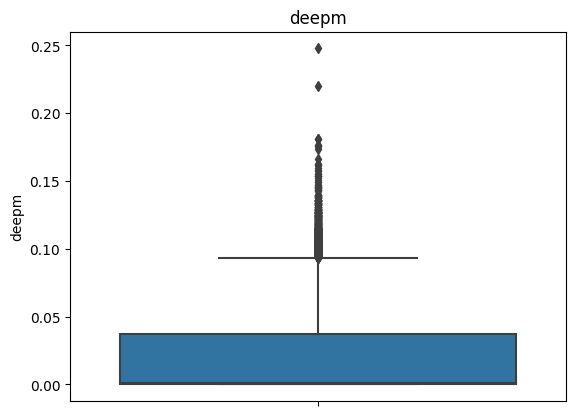

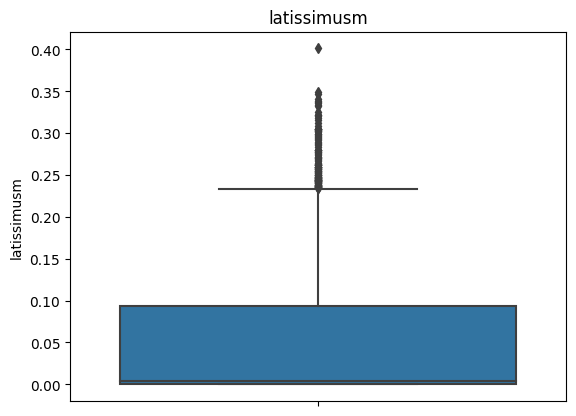

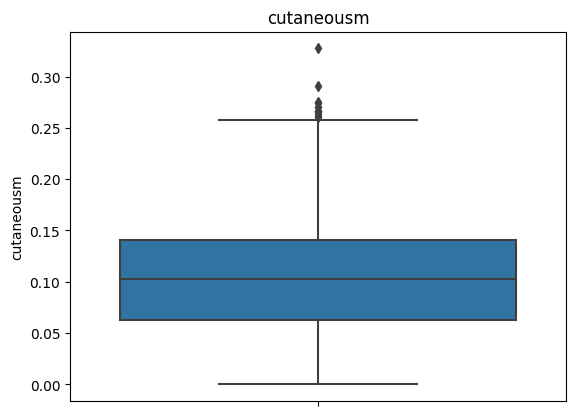

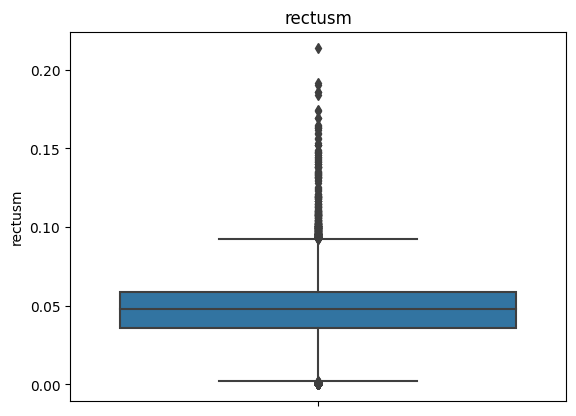

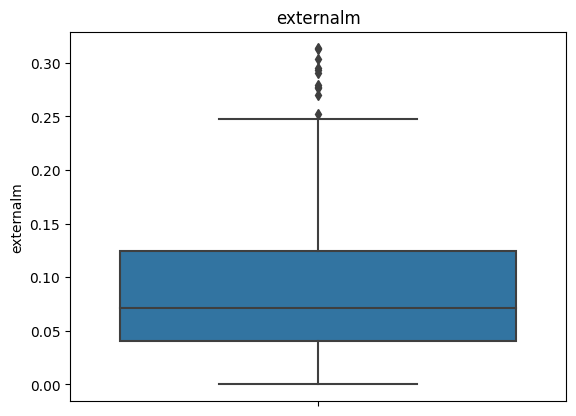

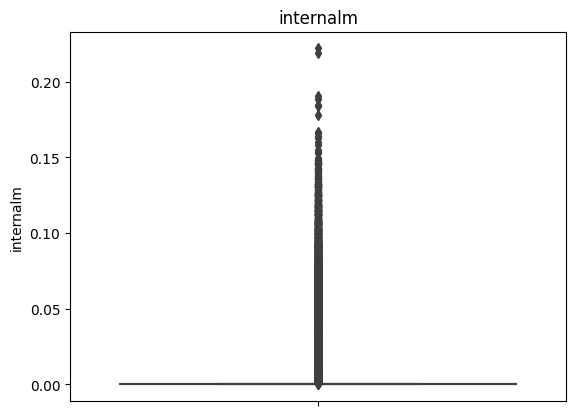

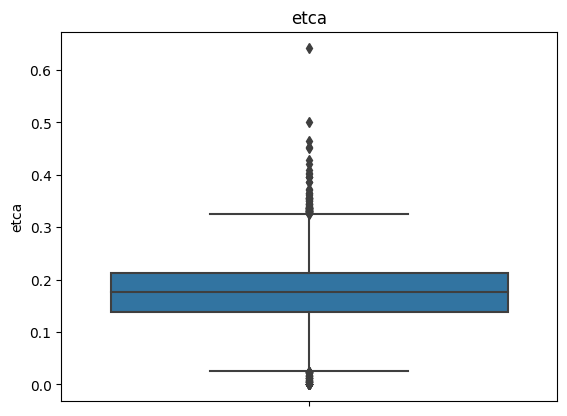

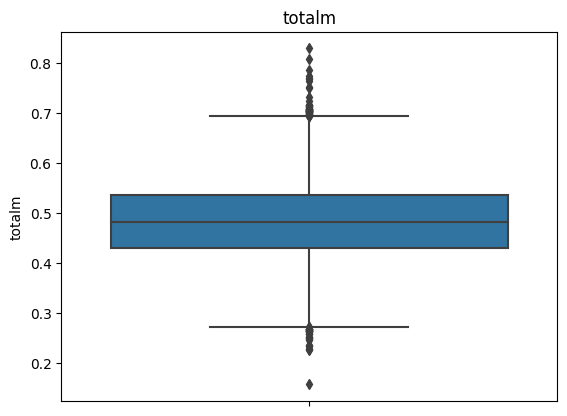

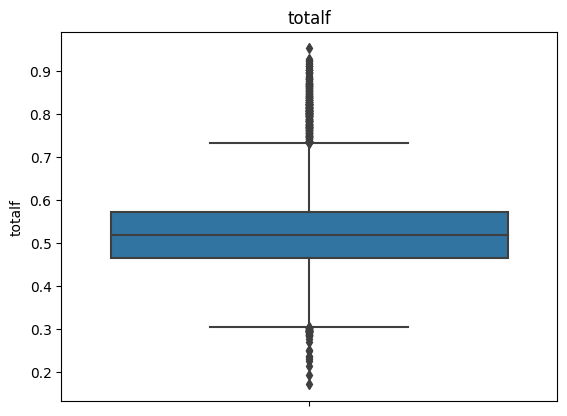

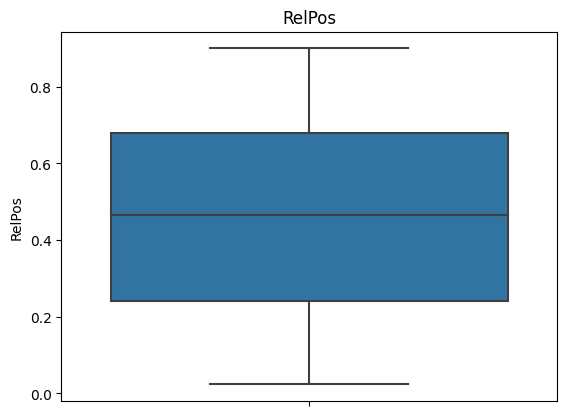

In [6]:
for col in df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']).columns:
    sns.boxplot(y = col, data = df_ratio)
    plt.title(col)
    plt.show()

# 적절한 군집 개수 찾기

## 계층적 군집분석 덴드로그램 확인

In [7]:
linkage_mat = linkage(y=df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']), method='ward')

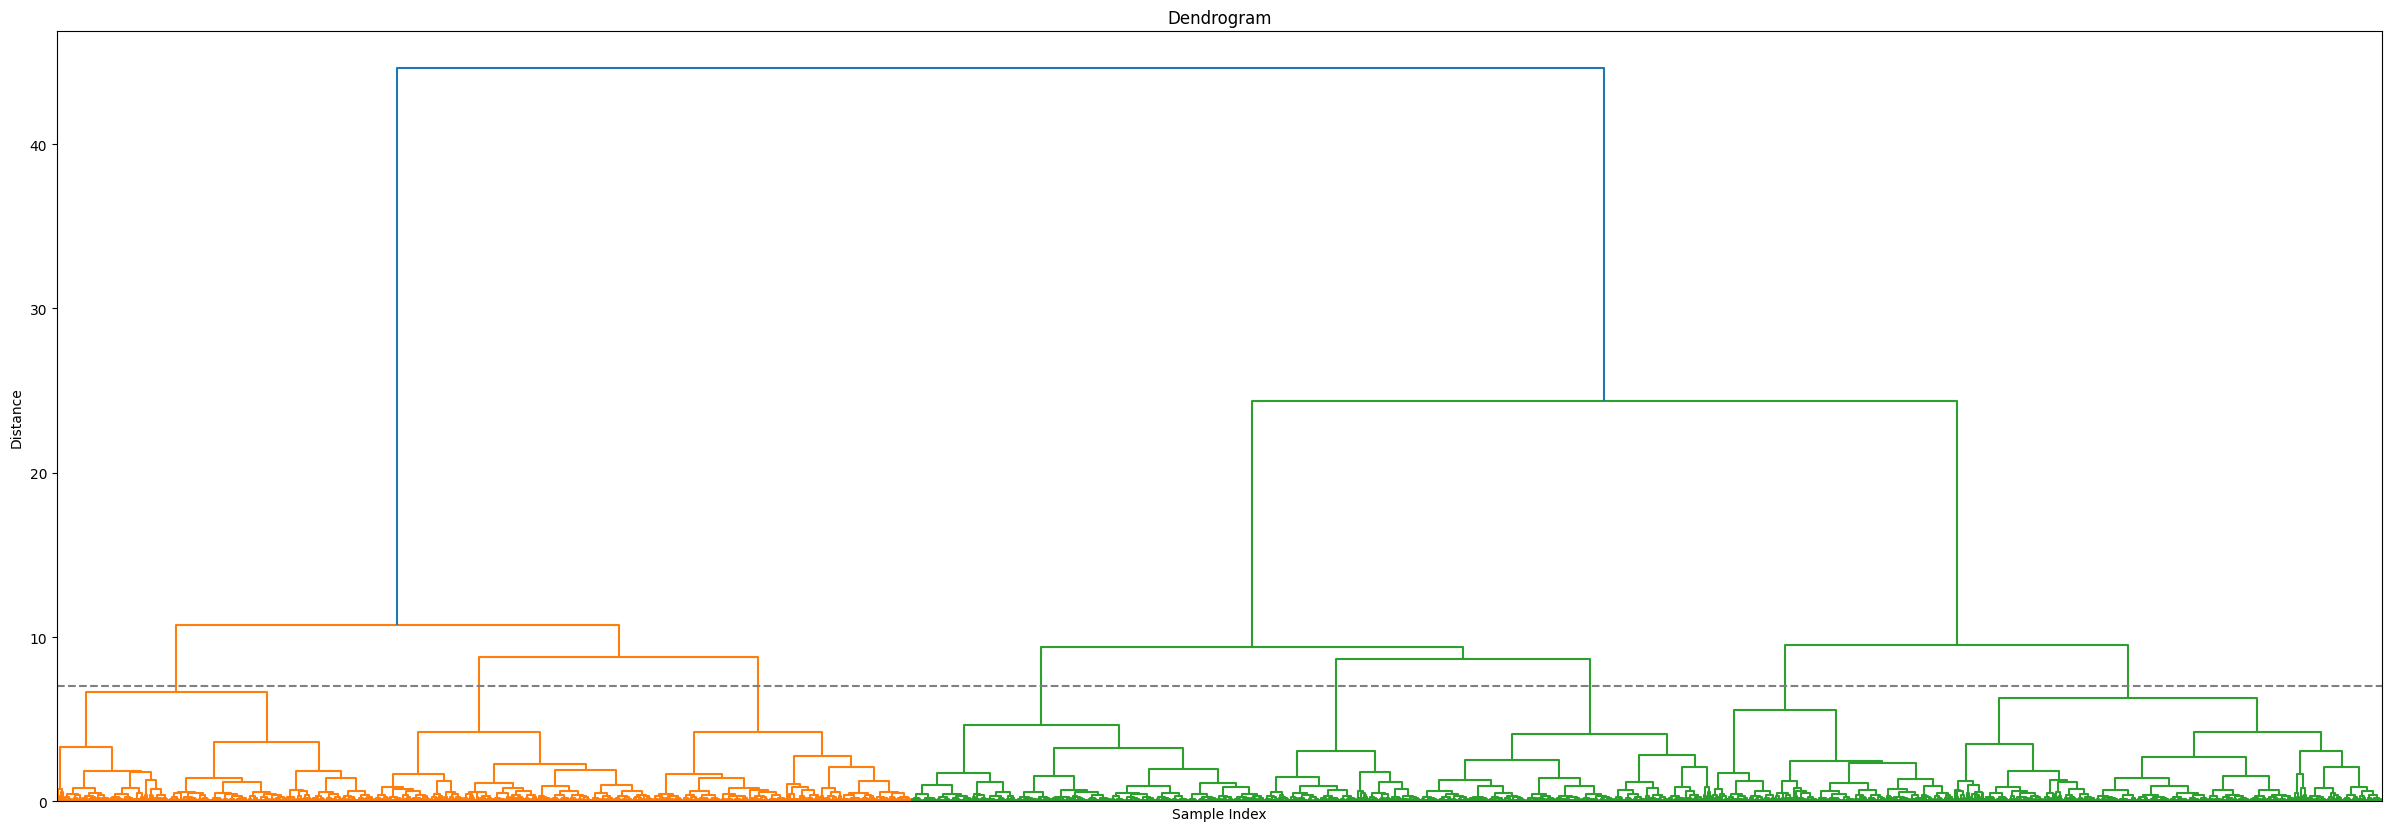

In [9]:
plt.figure(figsize = (30, 10))
dendrogram(linkage_mat, no_labels = True)

threshold = 7  # 추가할 수평선의 y-축 값
plt.axhline(y=threshold, color='grey', linestyle='--', label=f'Threshold = {threshold}')

plt.xticks(rotation=90)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

plt.show() 

## Elbow Method

In [15]:
df_ratio.columns

Index(['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'deepm',
       'latissimusm', 'cutaneousm', 'rectusm', 'externalm', 'internalm',
       'etca', 'totalm', 'totalf', 'pmuscle', 'MFratio', 'RelPos', 'cluster'],
      dtype='object')

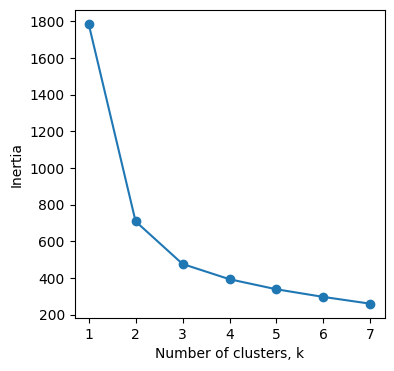

In [8]:
ks = range(1,8)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

## Silhouette Score

In [8]:
# ks = range(2,12)
# silhouette_scores = []

# for k in ks:
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
#     score = silhouette_score(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']), kmeans.labels_)
#     silhouette_scores.append(score)

# best_k = silhouette_scores.index(max(silhouette_scores)) + 2

In [9]:
# best_k

## PCA를 통한 군집 확인

In [9]:
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

In [10]:
sum(pca.explained_variance_ratio_)

0.9499619630734104

In [11]:
df_ratio_pca = pd.concat([df_ratio, principalDf], axis = 1)

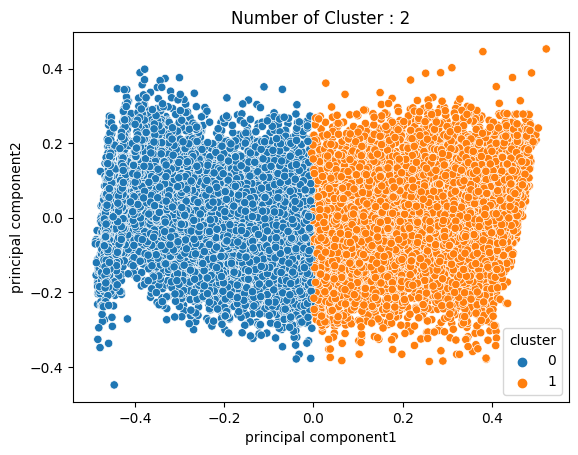

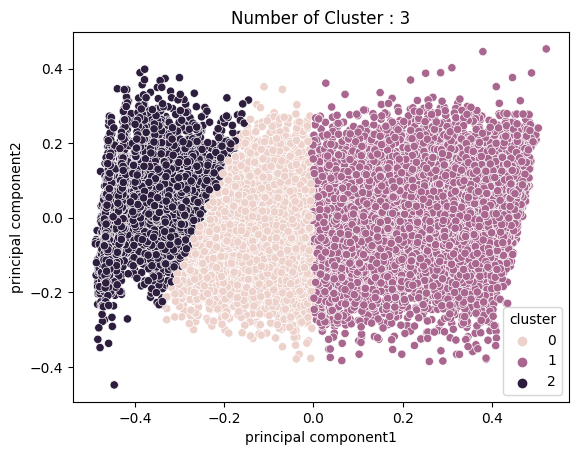

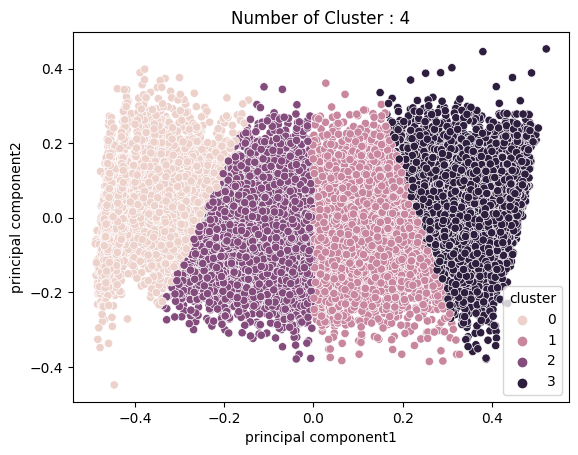

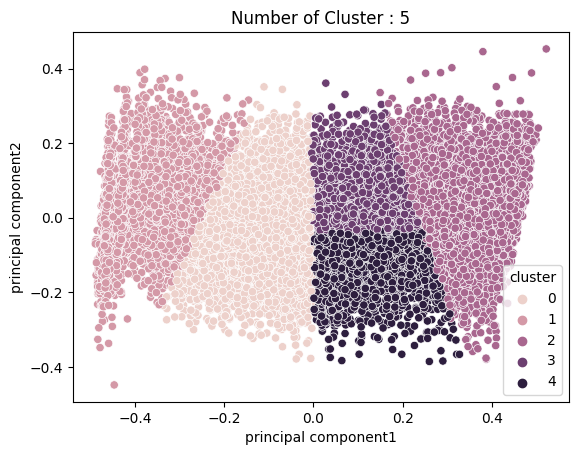

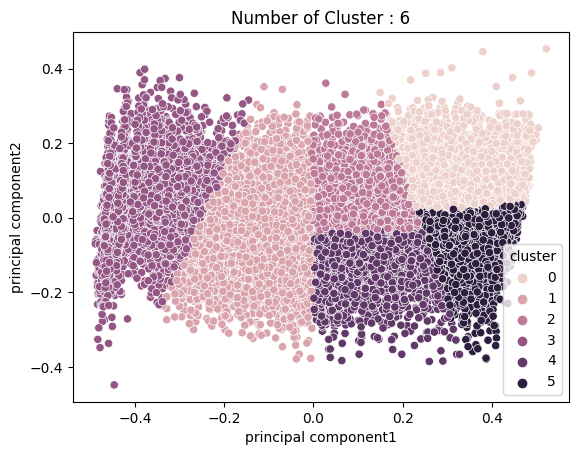

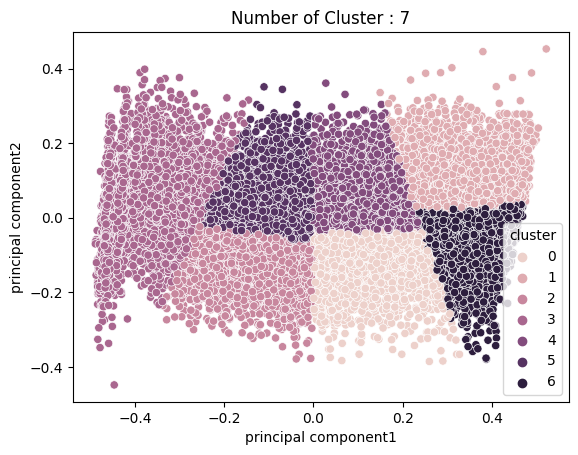

In [12]:
ks = range(2,8)

for k in ks:
    model = KMeans(n_clusters = k, random_state = 0)
    model.fit(df_ratio_pca.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
    df_ratio_pca['cluster'] = model.fit_predict(df_ratio_pca.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
    
    sns.scatterplot(x = 'principal component1', y = 'principal component2', hue = 'cluster', data = df_ratio_pca) 
    plt.title(f'Number of Cluster : {k}')
    plt.show()

# 군집 후 변수확인

In [13]:
model = KMeans(n_clusters = 3, random_state = 0)
model.fit(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
df_ratio['cluster'] = model.fit_predict(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))

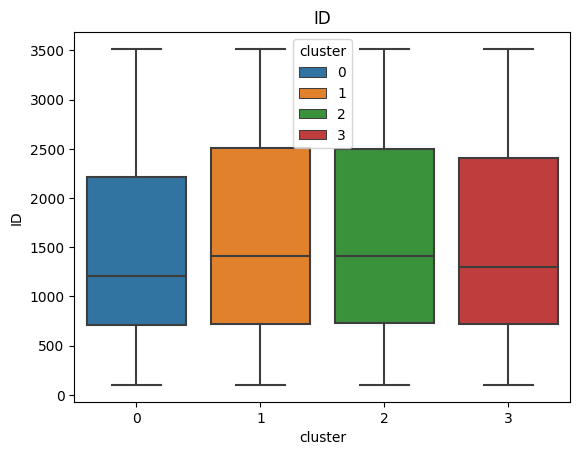

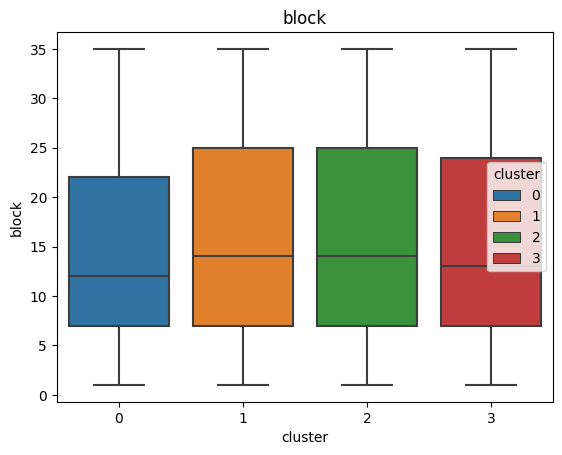

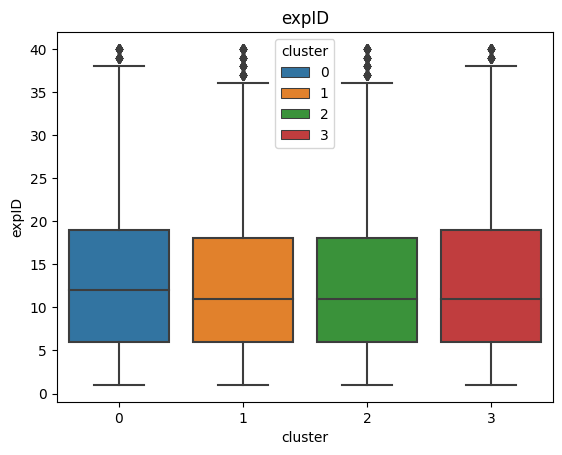

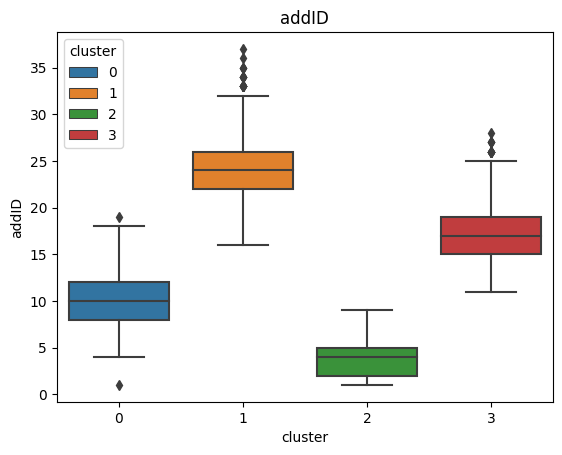

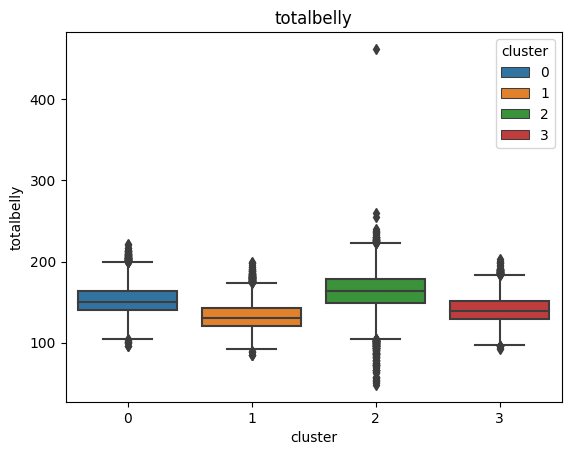

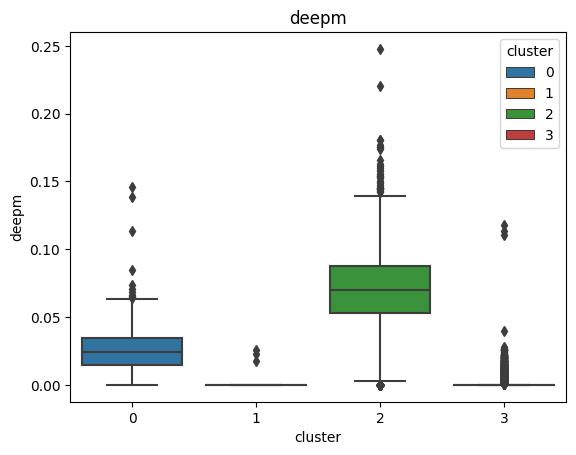

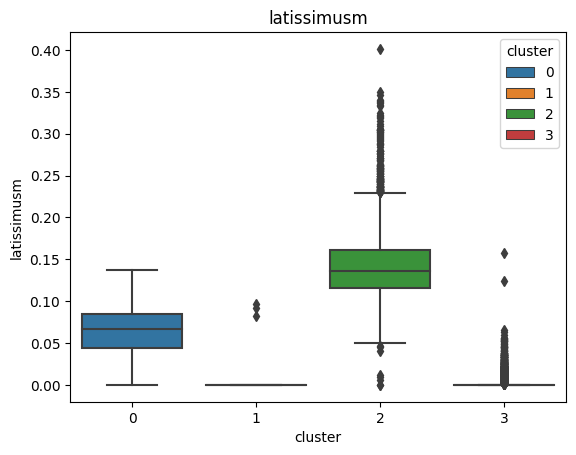

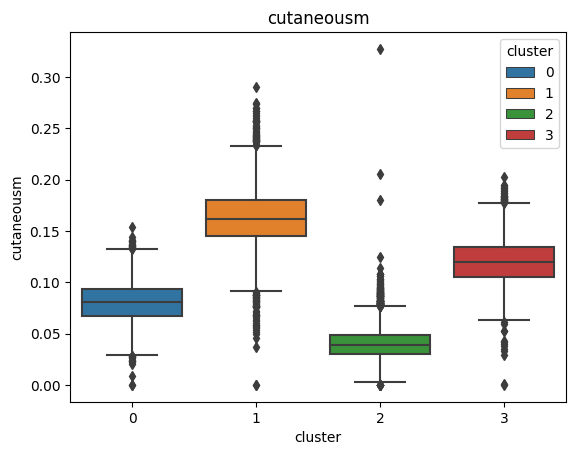

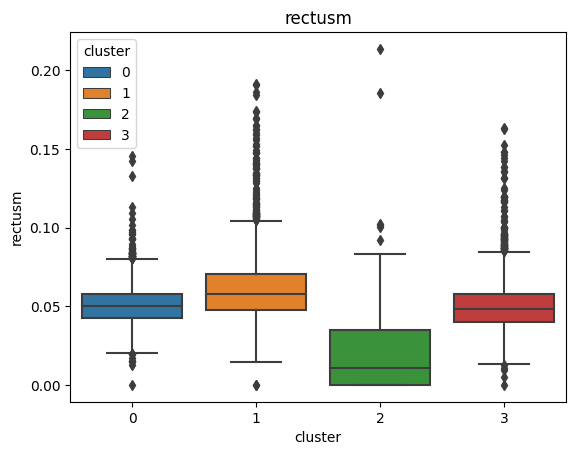

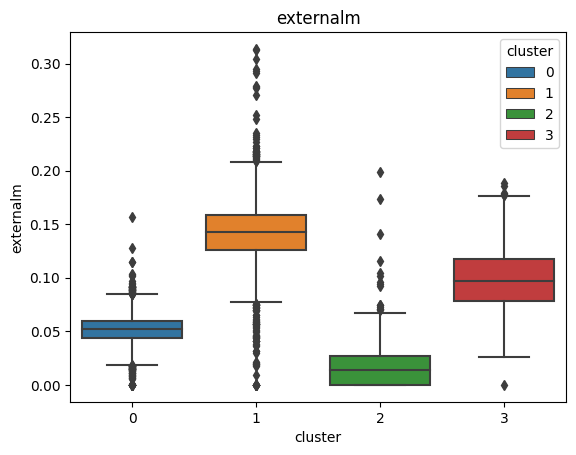

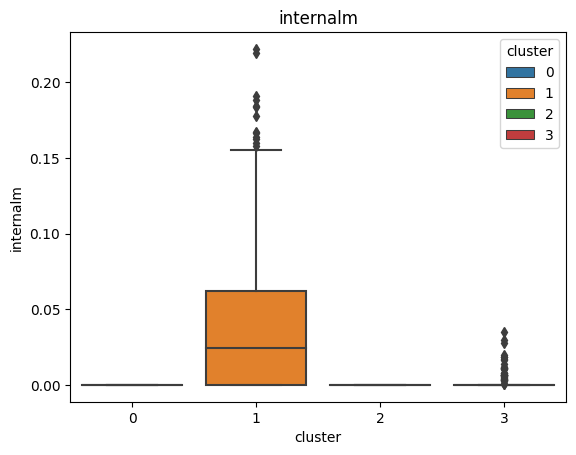

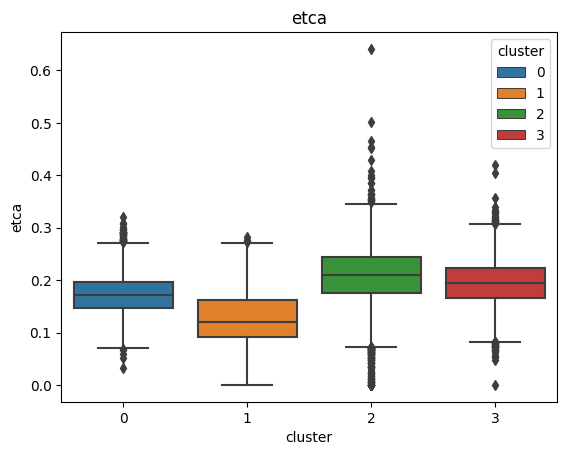

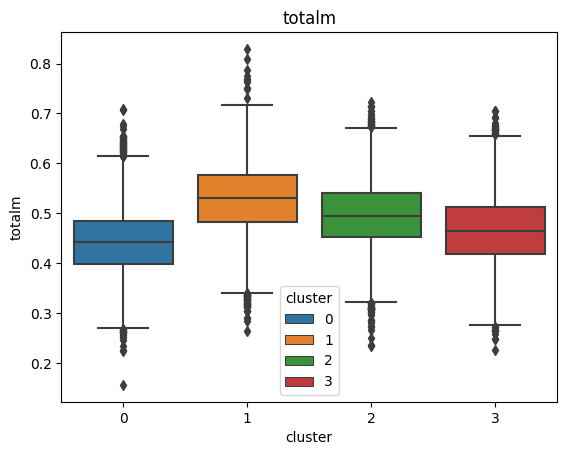

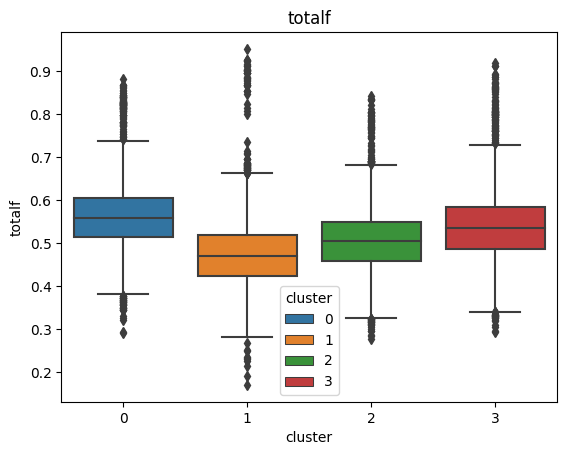

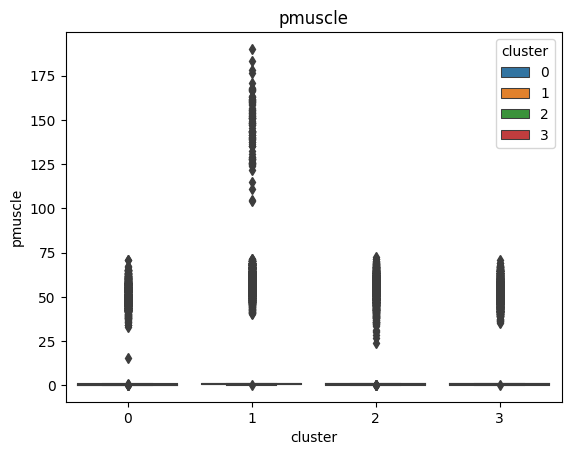

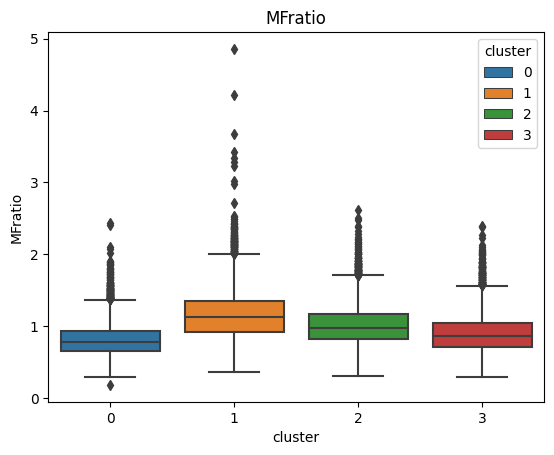

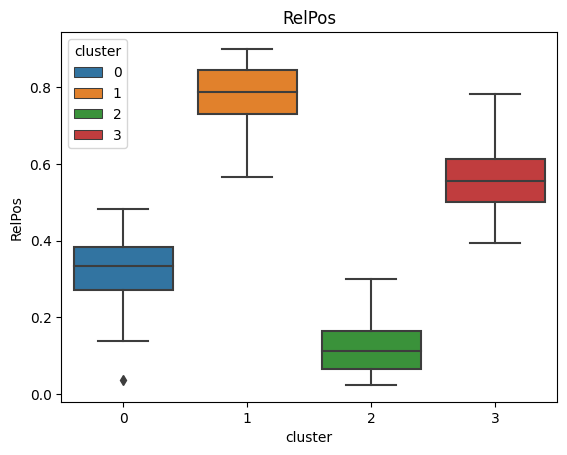

In [14]:
for col in df._get_numeric_data().columns.tolist():
    sns.boxplot(x = 'cluster', y = col, hue = 'cluster', data = df_ratio, dodge = False)
    plt.title(col)
    plt.show()

In [19]:
df_ratio.MFratio

0        0.888344
1        0.951278
2        0.855503
3        1.013603
4        0.887602
           ...   
19278    1.057266
19279    1.010818
19280    1.072700
19281    1.199783
19282    1.272332
Name: MFratio, Length: 19283, dtype: float64

In [20]:
from scipy import stats

t, p = stats.ttest_ind(df_ratio.MFratio[df_ratio.cluster == 0], df_ratio.MFratio[df_ratio.cluster == 1], equal_var= False)

In [21]:
p

0.0

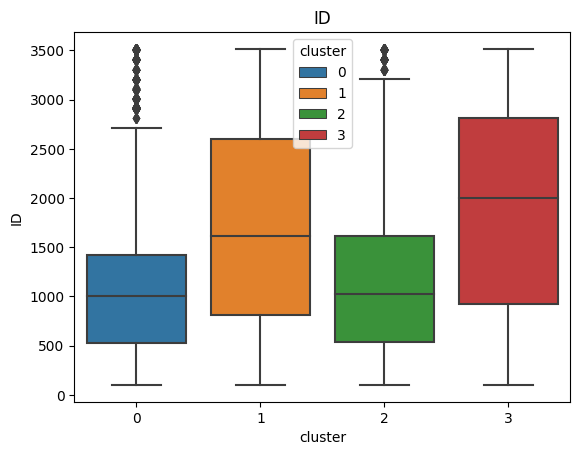

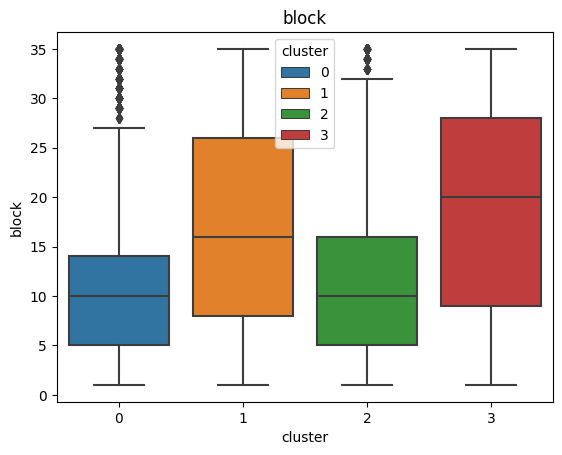

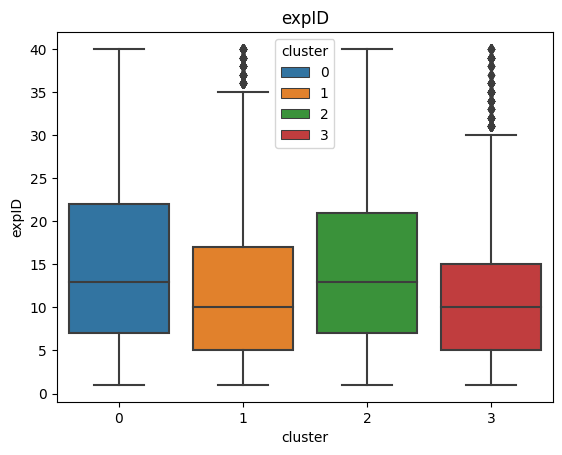

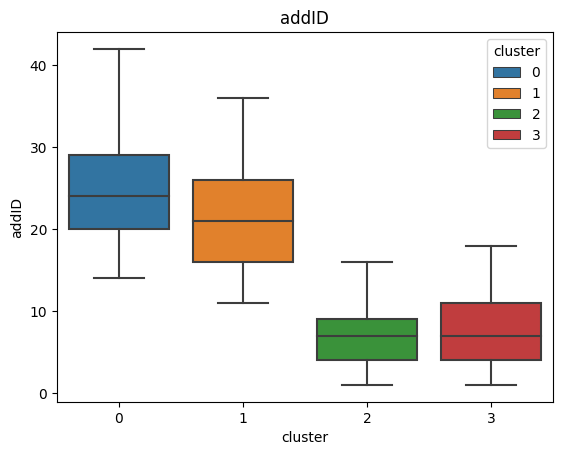

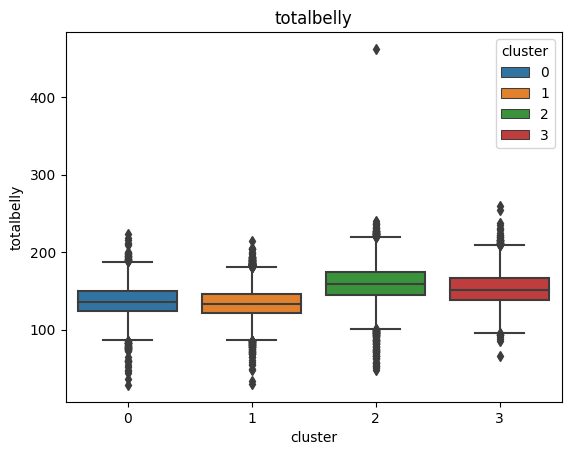

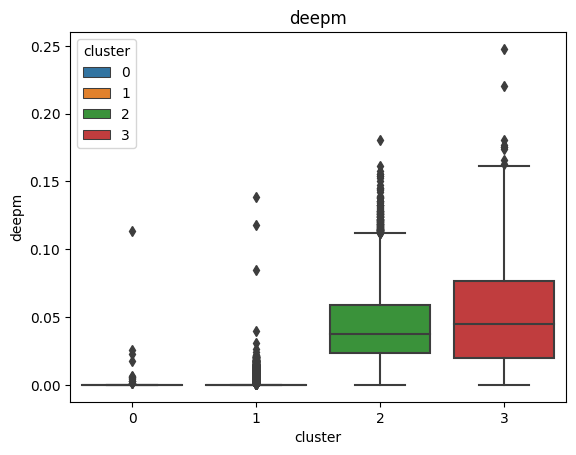

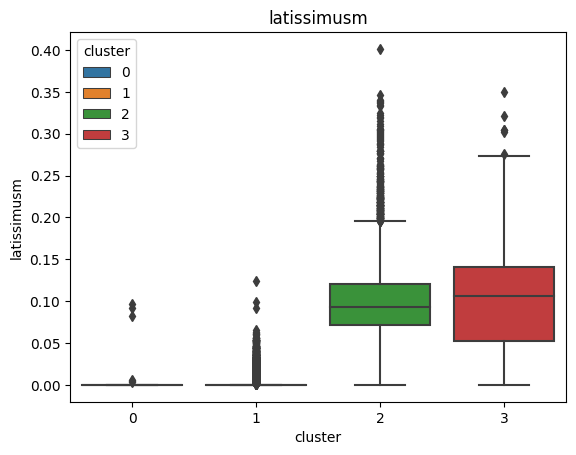

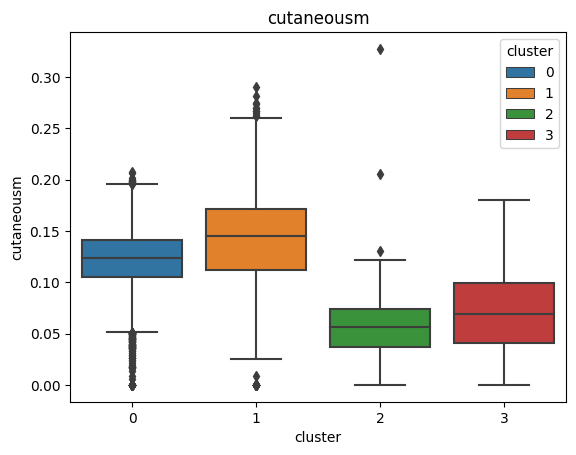

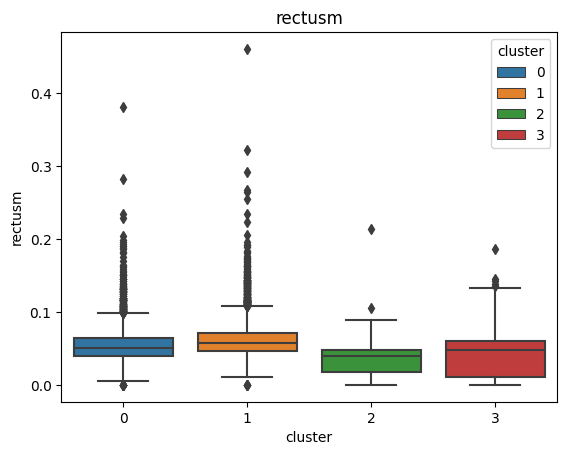

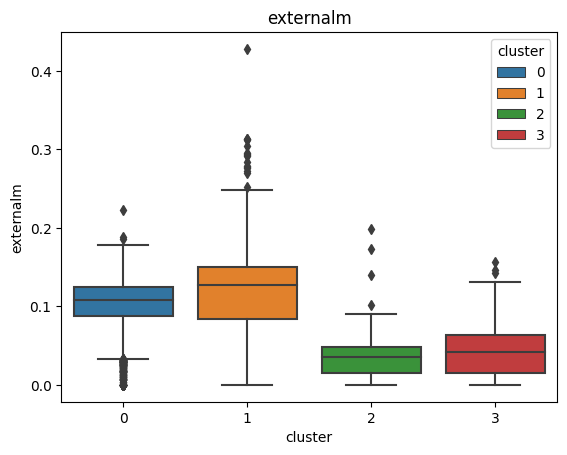

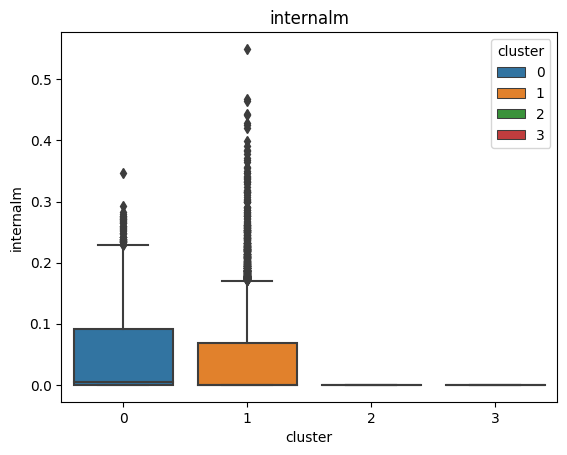

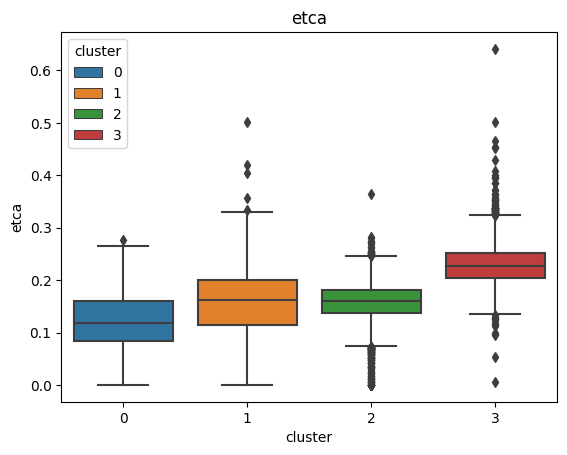

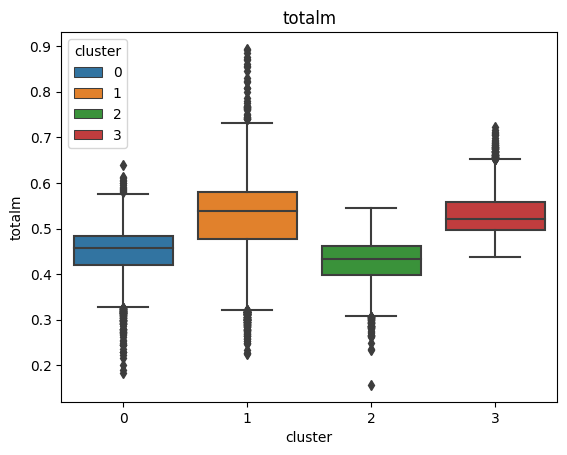

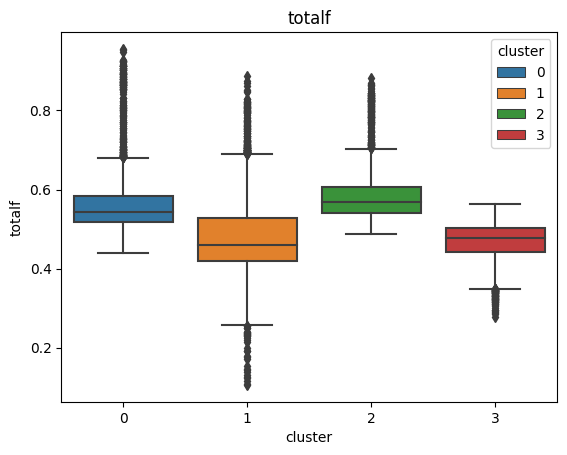

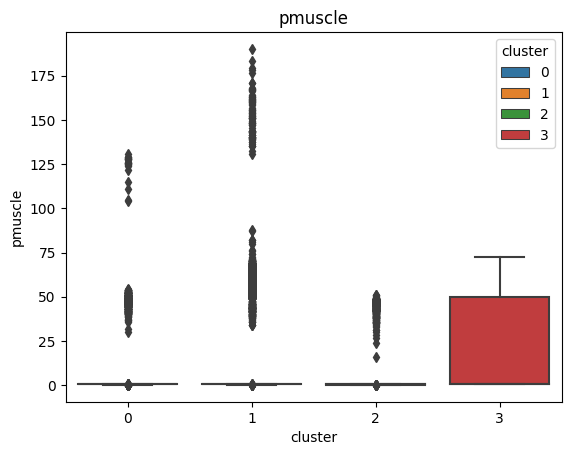

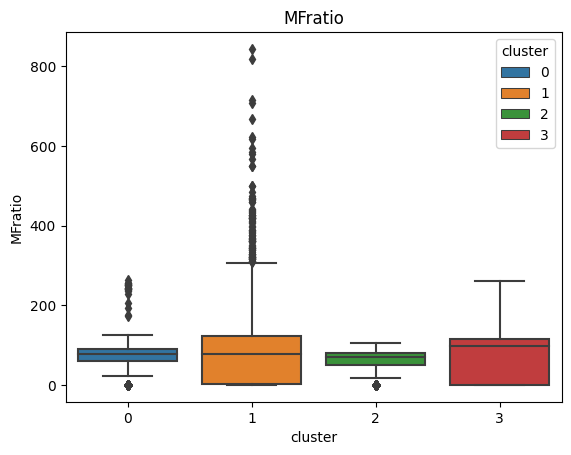

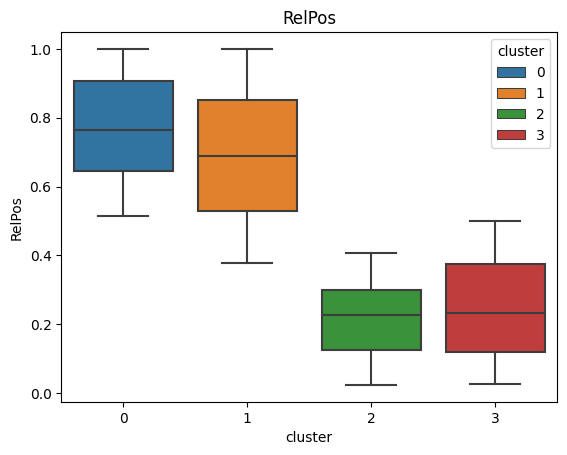

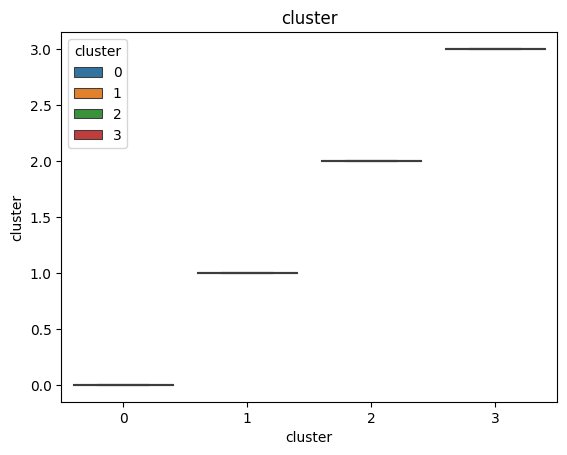

In [29]:
for col in df_ratio._get_numeric_data().columns.tolist():
    sns.boxplot(x = 'cluster', y = col, hue = 'cluster', data = df_ratio, dodge = False)
    plt.title(col)
    plt.show()

In [16]:
model = KMeans(n_clusters = 9, random_state = 0)
model.fit(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))
df_ratio['cluster'] = model.fit_predict(df_ratio.drop(columns = ['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'pmuscle', 'MFratio']))

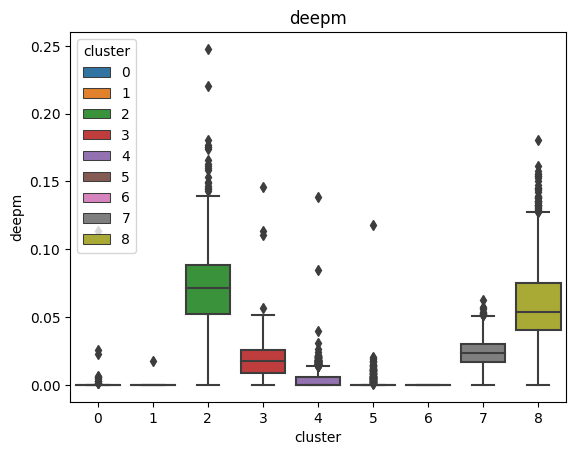

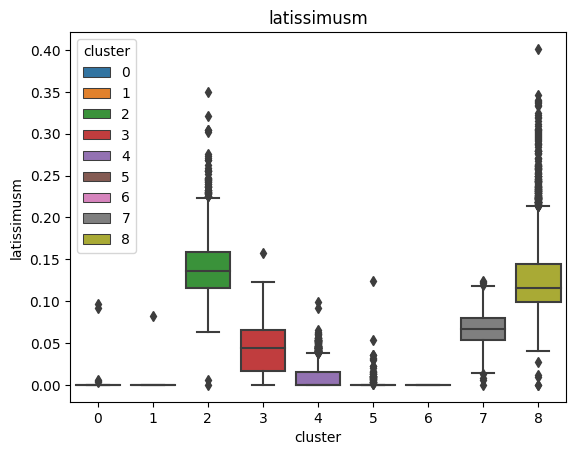

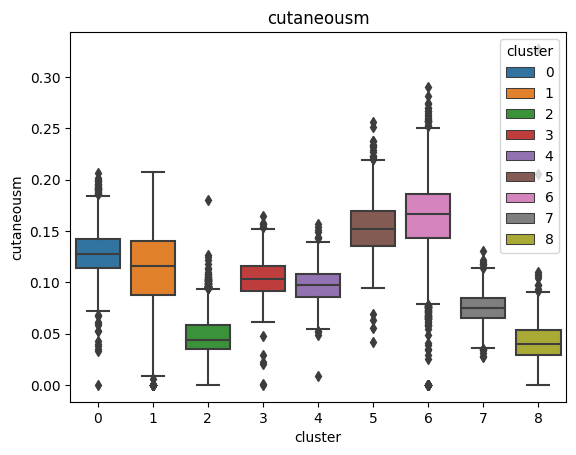

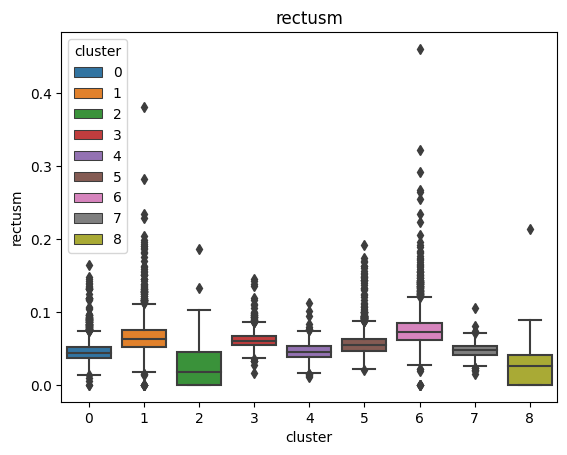

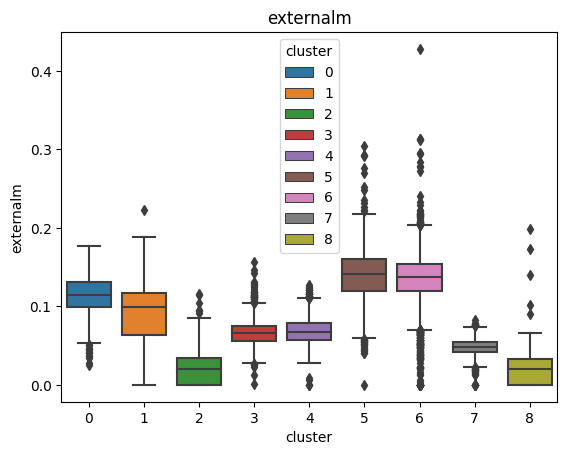

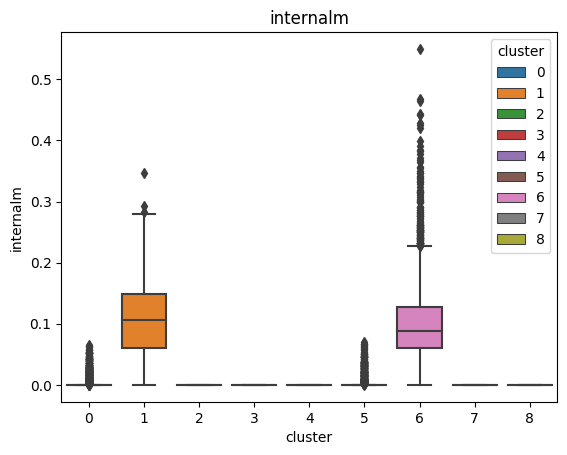

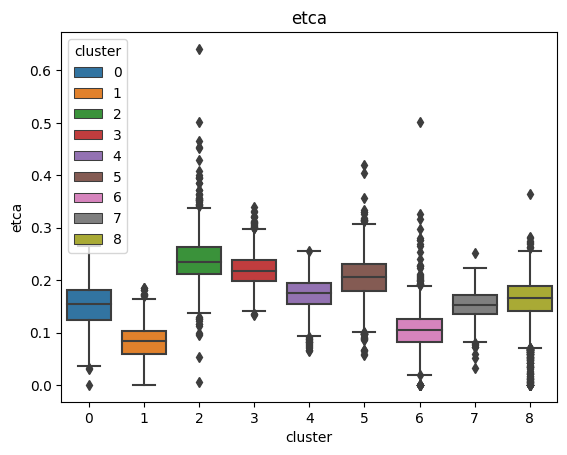

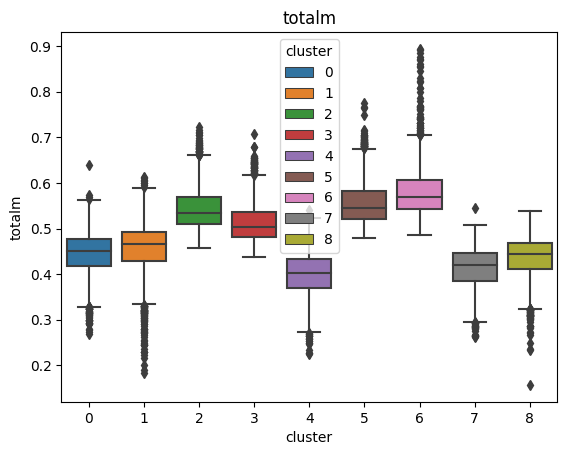

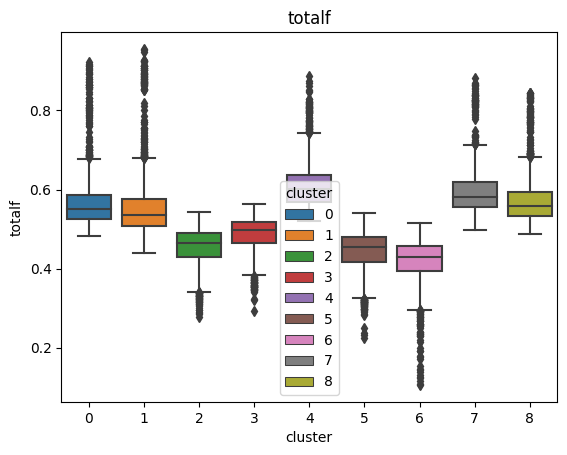

In [17]:
for col in ['deepm', 'latissimusm', 'cutaneousm', 'rectusm', 'externalm', 'internalm', 'etca', 'totalm', 'totalf'] :
    sns.boxplot(x = 'cluster', y = col, hue = 'cluster', data = df_ratio, dodge = False)
    plt.title(col)
    plt.show()

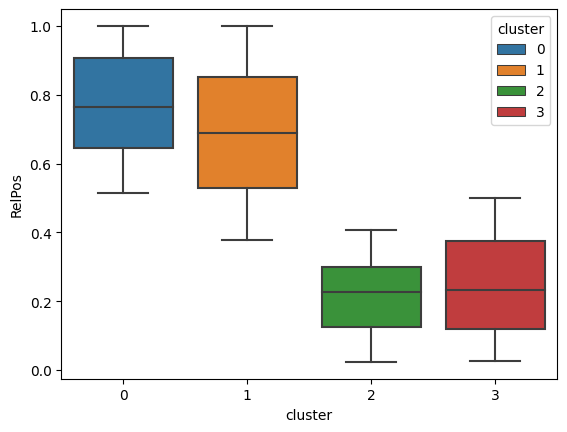

In [26]:
sns.boxplot(x = 'cluster', y = 'RelPos', hue = 'cluster', data = df_ratio, dodge = False)
plt.show()

In [27]:
df_ratio.columns

Index(['ID', 'block', 'expID', 'addID', 'newID', 'totalbelly', 'deepm',
       'latissimusm', 'cutaneousm', 'rectusm', 'externalm', 'internalm',
       'etca', 'totalm', 'totalf', 'pmuscle', 'MFratio', 'RelPos', 'cluster'],
      dtype='object')

In [ ]:
sns.boxplot(x = 'cluster', y = 'RelPos', hue = 'cluster', data = df_ratio, dodge = False)
plt.show()